# Домашняя работа 3. Логистическая регрессия.

### Оценивание и штрафы

Максимальная оценка — 10 баллов.

Не списывайте, иначе всем участникам обнулим :)

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка: ...**

In [1]:
print('Всем удачи!👒')

Всем удачи!👒


In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Логистическая регрессия

Модель логистической регрессии:
  $$
  \hat y = \sigma (Xw).
  $$
  Сигмоида меняется в пределах от 0 до 1 и имеет вид:
  $$
  \sigma(x) = \frac{1}{1+e^{-x}}.
  $$

  Функция потерь log-loss:
  $$
  L = -\frac{1}{\ell}\sum_{i = 1}^{\ell}(y_i\log(\hat y_i) + (1 - y_i)\log(1 - \hat y_i)),
  $$
  где $\ell$ - количество объектов.

## Градиентный спуск

Итеративный метод оптимизации, при котором вектор весов модели $\mathbf{w}^{(t+1)}$ на шаге $t+1$ может быть выражен как:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta_t \nabla L(\mathbf{w}^{(t)}),
$$
где $\eta_t$ - шаг обучения.

## Часть 1. Логрег своими руками

**Задание 1 (8 баллов)**. Реализуйте логистическую регрессию, обучаемую с помощью:
- градиентного спуска **(4 балла)**

- стохастического градиентного спуска **(4 балла)**

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавим атрибут класса `loss_history`. В нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [3]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-4,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Args:
          gd_type: Type of gradient descent ('full' or 'stochastic').

          tolerance: Threshold for stopping gradient descent.

          max_iter: Maximum number of steps in gradient descent.

          eta: Learning rate.

          w0: Array of shape d (d — number of weights to optimize).
              Initial weights.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None

    def fit(self, X: np.array, y: np.array) -> LogReg:
        """Fit the model on training data. Also, save value of loss after each iteration.

        Args:
          X: Training data.

          y: Target.

        Returns:
          self: Fitted classsifier.
        """
        self.loss_history = []
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        if self.w0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = self.w0.copy()

        for i in range(self.max_iter):
            w_prev = self.w.copy()

            gradient = self.calc_gradient(X, y)
            self.w = self.w - self.eta * gradient
            
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            
            if np.linalg.norm(self.w - w_prev) < self.tolerance:
                break
                
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Calculate probability of positive and negative class for each observation.

        Args:
          X: Array of shape (n, d).
             Data.

        Returns:
             Array of shape (n, 2).
             Predicted probabilities.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        proba_positive = 1 / (1 + np.exp(-X @ self.w))
        proba_negative = 1 - proba_positive
        
        return np.column_stack([proba_negative, proba_positive])


    def predict(self, X: np.array) -> np.array:
        """Predict class for each observation.

        Args:
          X: Array of shape (n, d).
             Data.

        Returns:
             Array of shape (n,).
             Predicted class labels.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        else:
            y_pred = np.round(self.predict_proba(X)[:, 0])
        return y_pred

    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Calculate gradient of loss function after each iteration.

        Args:
          X: Array of shape (n, d), n can be equal to 1 if 'stochastic'.
          y: Array of shape (n,).

        Returns:
          Array of shape (d,).
          Gradient of loss function after current iteration.
        """
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        proba_positive = 1 / (1 + np.exp(-X @ self.w))
        
        if self.gd_type == 'full':
            gradient = (1 / X.shape[0]) * X.T @ (proba_positive - y)
        elif self.gd_type == 'stochastic':
            i = np.random.randint(X.shape[0])
            gradient = (proba_positive[i] - y[i]) * X[i, :]
        
        return gradient

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Calculate value of loss function after each iteration.

        Args:
          X: Array of shape (n, d).
          y: Array of shape (n,).

        Returns:
          Value of loss function after current iteration.
        """
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        probas = self.predict_proba(X)
        probas = np.clip(probas, 1e-15, 1 - 1e-15)
        loss = (-1 * np.sum(y * np.log(probas[:, 1]) + (1 - y) * np.log(probas[:, 0]))) / X.shape[0]
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем синтетические данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Задание 2 (1 балл).** Обучите логистическую регрессию на синтетических данных. Нарисуйте кривую обучения.

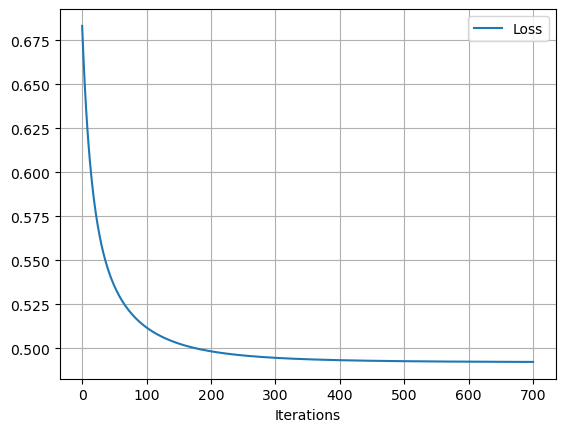

In [5]:
classifier = LogReg(gd_type='full')
classifier.fit(X_train, y_train)

plt.plot(classifier.loss_history, label="Loss")

plt.xlabel("Iterations")

plt.grid()
plt.legend()
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

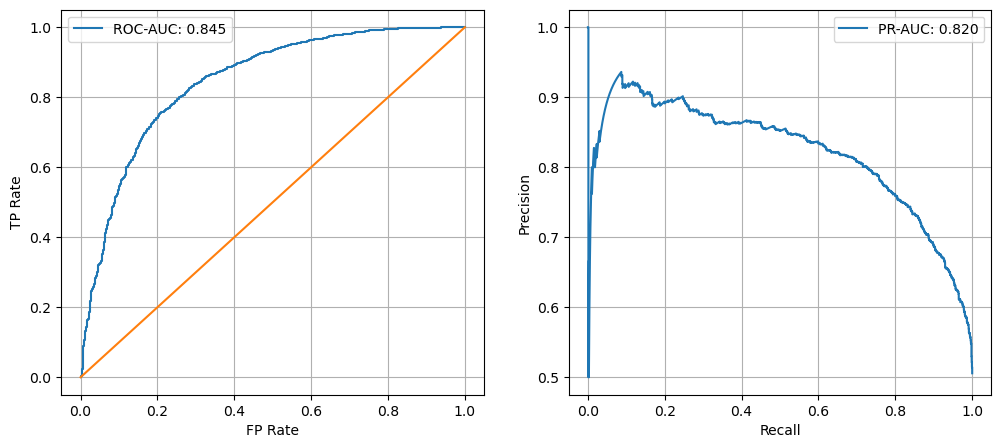

In [6]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

y_proba = classifier.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# ROC
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC-AUC: {roc_auc:.3f}')
plt.plot([0, 1], [0, 1])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend()
plt.grid(True)

# PR 
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR-AUC: {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс валидации.  

In [7]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

roc_scores = []
pr_scores = []

for train_idx, val_idx in kf.split(X):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    classifier.fit(X_train_fold, y_train_fold)
    
    y_proba = classifier.predict_proba(X_val_fold)[:, 1]
    
    roc_scores.append(roc_auc_score(y_val_fold, y_proba))
    pr_scores.append(average_precision_score(y_val_fold, y_proba))

print("ROC-AUC:", [score for score in roc_scores])
print("PR-AUC: ", [score for score in pr_scores])

print(f"mean ROC-AUC: {np.mean(roc_scores):.3f}")
print(f"mean PR-AUC:  {np.mean(pr_scores):.3f}")

ROC-AUC: [0.8435043268480623, 0.8490070336161798, 0.8422724421469868, 0.8545732789877722, 0.8516550948170927]
PR-AUC:  [0.8166885442000897, 0.8275012070645094, 0.809569224094538, 0.8095982215763005, 0.8037269145276169]
mean ROC-AUC: 0.848
mean PR-AUC:  0.813
